## SPAM SMS Detection

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,f1_score

In [3]:
data = pd.read_csv('spam.csv',encoding='ISO 8859-1')

In [4]:
data.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
data.fillna(' ',inplace=True)
data['text_message'] = data['v2'] + data['Unnamed: 2'] + data['Unnamed: 3'] + data['Unnamed: 4']

In [7]:
data1 = data[['v1','text_message']]
data1.dropna(inplace=True)
data1['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

## preprocessing

In [8]:
# remove whitespaces
data1['text_message']=data1['text_message'].str.strip()

In [9]:
# lowercase the text
data1['text_message'] = data1['text_message'].str.lower()

In [10]:
#remove punctuation
punc = string.punctuation
table = str.maketrans('','',punc)
data1['text_message']=data1['text_message'].apply(lambda x: x.translate(table))

In [11]:
# tokenizing each message
data1['word_tokens']=data1.apply(lambda x: x['text_message'].split(' '),axis=1)

In [12]:
# removing stopwords
data1['cleaned_text'] = data1.apply(lambda x: [word for word in x['word_tokens'] if word not in stopwords.words('english')],axis=1)

In [13]:
# stemming
ps = PorterStemmer()
data1['stemmed']= data1.apply(lambda x: [ps.stem(word) for word in x['cleaned_text']],axis=1)

In [14]:
# remove single letter words
data1['final_text'] = data1.apply(lambda x: ' '.join([word for word in x['stemmed'] if len(word)>1]),axis=1)

In [15]:
# label encoding ham=0 and spam=1
data1.loc[data1['v1']=='ham','v1']=0
data1.loc[data1['v1']=='spam','v1']=1

In [16]:
# divide the set in training and test
from sklearn.model_selection import train_test_split
X,X_test,y,y_test = train_test_split(data1.loc[:,'text_message':],data1['v1'],test_size=0.2)

In [17]:
# Now we'll create a vocabulary for the training set with word count
vocab=defaultdict(int) 
for text in X['final_text'].values:
    for elem in text.split(' '):
        vocab[elem]+=1

Text(0.5, 1.0, 'HAM')

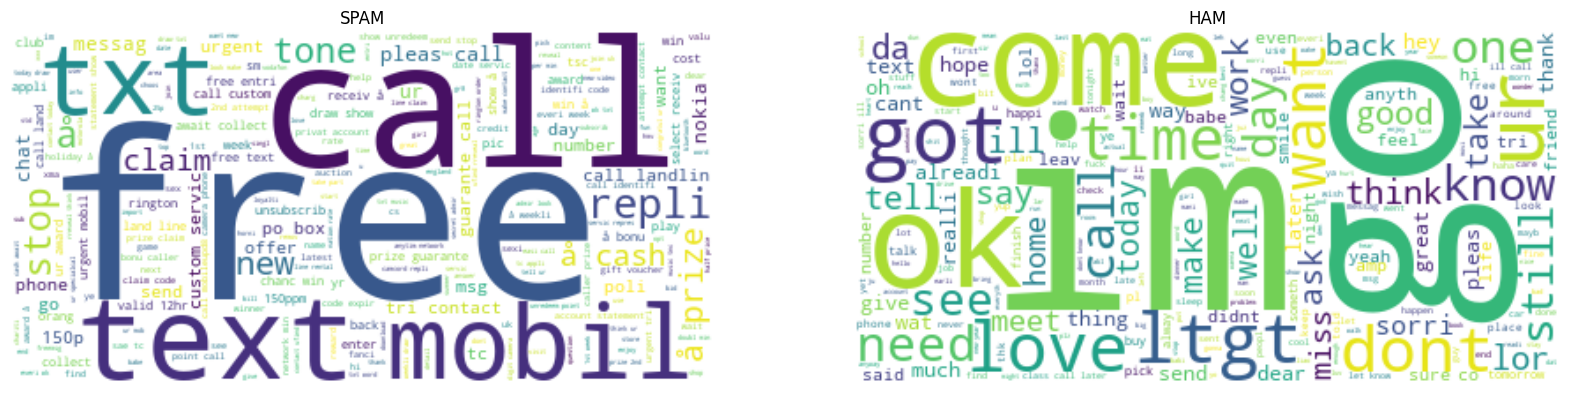

In [18]:
# Now we look at the types of words in ham and spam.
ham_text=' '.join(X.loc[y==0,'final_text'].values)
ham_wordcloud = WordCloud(background_color='white',max_words=2000).generate(ham_text)
spam_text=' '.join(X.loc[y==1,'final_text'].values)
spam_wordcloud = WordCloud(background_color='white',max_words=2000).generate(spam_text)
plt.figure(figsize=[20,30])
plt.subplot(1,2,1)
plt.imshow(spam_wordcloud,interpolation='bilinear')
plt.title('SPAM')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('HAM')

In [19]:
# Found that call, free text, claim etc are the most used words in spam.

In [20]:
# tokenize the text for further calculations
X['tokenized_final_text']=X['final_text'].str.split(' ')
X_test['tokenized_final_text']=X_test['final_text'].str.split(' ')

In [21]:
# document frequency(number of docs containing word w) and Inverse document frequency(measures rarity of each word)
df={}
for k in vocab.keys():
    df[k]=np.sum(X['tokenized_final_text'].apply(lambda x: 1 if k in x else 0))
    
# Now we'll calculate the idf score of each word
idf = {k:1+np.log((1+X.shape[0]/(1+v))) for k,v in df.items()}

In [22]:
# tf * idf
for elem in vocab.keys():
    X[elem]= X['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)
for elem in vocab.keys():
    X_test[elem]= X_test['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)

In [23]:
y=y.astype('int')
y_test = y_test.astype('int')

## applying logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X.iloc[:,6:],y)
confusion_matrix(y,lr.predict(X.iloc[:,6:]))

array([[3870,    0],
       [   0,  587]], dtype=int64)

In [27]:
confusion_matrix(y_test,lr.predict(X_test.iloc[:,6:]))

array([[955,   0],
       [ 19, 141]], dtype=int64)

In [31]:
print('logistic regression')
print('f1 score ----------',f1_score(y_test,lr.predict(X_test.iloc[:,6:])))
print('accuracy score-----',lr.score(X_test.iloc[:,6:],y_test))

logistic regression
f1 score ---------- 0.93687707641196
accuracy score----- 0.9829596412556054


In [246]:
ham_20 = np.argsort(lr.coef_)[0][:20]
spam_20  = np.argsort(lr.coef_)[0][-20:]

In [247]:
features = X.iloc[:,6:].columns
print('------------SPAM FEATURES------------')
for elem in spam_20:
    print(features[elem])
    
print('------------HAM FEATURES------------')
for elem in ham_20:
    print(features[elem])
    

------------SPAM FEATURES------------
18
immedi
08712400200
08718738034
stop
repli
prize
ringtonek
84484
88066
mobil
urgent
voicemail
rington
servic
946
filthi
claim
txt
07090201529
------------HAM FEATURES------------
ltgt
sir
ok
ill
later
home
da
come
still
like
that
way
im
work
yup
say
cant
ìï
got
happi


In [238]:
len(lr.coef_[0])

7255